In [13]:
import pandas as pd
import os
import ast
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format

In [14]:
all_results = []
for f in os.listdir('.'):
    if '.data' in f:
        with open(f, 'r') as g:
            all_results.append(ast.literal_eval(g.read()))

In [15]:
def standardize_to_uM(concentration, unit, sequence):
    concentration = concentration.replace(' ', '')
    try:
        concentration = float(concentration)
    except:
        return None
    if unit == 'uM' or unit == u'\xb5M' or unit == u'uM)':
        return concentration
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000/molWt
    elif unit == 'nmol/g' or unit == 'pmol/mg':
        #1g, at density of 1g/mL, is 1mL, so nmol/g is nmol/mL = umol/L = uM yay!
        return concentration
    else:
        # print 'Unit not recognized: ' + unit
        return None

In [16]:
def convert_result_to_rows(sequence, result):
    rows = []
    if 'bacteria' not in result:
        return rows
    for bacterium, strain in result['bacteria']:
        
        rows.append({
            'bacterium': bacterium,
            'strain': strain,
            'sequence': sequence.upper(),
            'url_source': result['url_sources'][0],
            'value': standardize_to_uM(
                result['bacteria'][(bacterium, strain)]['value'],
                result['bacteria'][(bacterium, strain)]['unit'],
                sequence
            ),
            'modifications': result['modifications'] if 'modifications' in result else [],
            'unit': 'uM'
        })
        if rows[-1]['value']:
            rows[-1]['value'] = np.log10(rows[-1]['value'])
    return rows

In [17]:
rows = []
for result_set in all_results:
    for sequence in result_set:
        for row in convert_result_to_rows(sequence, result_set[sequence]):
            rows.append(row)

In [18]:
df = pd.DataFrame(rows)

In [19]:
def is_modified(modifications_list):
    return len(modifications_list) > 0

df['is_modified'] = df.modifications.apply(is_modified)

In [20]:
def has_non_cterminal_modification(modifications_list):
    return any(['C-Term' not in modification for modification in modifications_list])

df['has_non_cterminal_modification'] = df.modifications.apply(has_non_cterminal_modification)
#df['has_non_cterminal_modification'] = df.groupby(['sequence'])['has_non_cterminal_modification'].transform(max)

df['has_cterminal_modification'] = df.is_modified & ~df.has_non_cterminal_modification
#df['has_cterminal_modification'] = df.groupby(['sequence'])['has_cterminal_modification'].transform(max)

In [21]:
# Clean sequences
df.sequence = df.sequence.str.strip()
df = df.loc[df.sequence != '/']

In [22]:
# Exclude sequences with modifications

# Exclude rows from YADAMP and CAMP for having no modification data

#     Unless that sequence is in another DB

In [23]:
df = df.loc[df.has_non_cterminal_modification == False]

no_modification_data_sources = ['camp3', 'yadamp']

def datasource_has_modifications(cell):
    # Everything except CAMP and YADAMP has modification data
    return not any([s in cell for s in no_modification_data_sources])

df['_datasource_has_modifications'] = df['url_source'].apply(datasource_has_modifications)

sequences_containing_modifications = set(df.loc[df._datasource_has_modifications == True, 'sequence'])
def sequence_has_modification_data(cell):
    # If the sequence is labeled modifictationless in another database it's OK
    return cell in sequences_containing_modifications

df['_sequence_has_modifications'] = df['sequence'].apply(sequence_has_modification_data)

df['modification_verified'] = df['_sequence_has_modifications'] | df['_datasource_has_modifications']

df = df.loc[df.modification_verified == True]

In [24]:
print(''.join(character_to_index.keys()))

NameError: name 'character_to_index' is not defined

In [117]:
character_dict = set([character for sequence in df.sequence for character in sequence])
max_sequence_length = int(df.sequence.str.len().describe(percentiles=[0.95])['95%'])

# Each amino acid its own group
character_to_index = {
    (character): i
    for i, character in enumerate(character_dict)
}

# Group them together heavily
character_to_index = {
    ('R', 'K', 'H'): 0,
    ('D', 'E'): 1,
    ('S', 'T', 'N', 'Q', 'C'): 2,
    ('A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'P', 'G'): 3,
    ('Z'): 4,
    ('X'): 5,
    ('U'): 6,
}

# Group them together more sparingly
character_to_index = {
    ('R'): 0,
    ('H'): 1,
    ('K'): 2,
    ('D', 'E'): 3,
    ('S', 'T', 'N', 'Q', 'C'): 4,
    ('G', 'P'): 5,
    ('A', 'V', 'I', 'L', 'M'): 6,
    ('F', 'Y', 'W'): 7,
    ('Z'): 8,
    ('X'): 9,
    ('U'): 10,
}

def sequence_to_vector(sequence, cterminal_amidation):
# It looks like this truncates any sequence after max_sequence_length (which is length of 95th percentile longest peptide)
# I just add cterminal amidation as the amino acid after the last real amino acid (if the amino acid gets truncated
# then the cterminal amidation also gets cut off)
    default = np.zeros([max_sequence_length, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:max_sequence_length]):
        default[i][character_to_index[character]] = 1
    if len(sequence)<max_sequence_length:
        default[len(sequence)][-1]=cterminal_amidation
    return default

def old_sequence_to_vector(sequence, cterminal_amidation):
#     Chops off any sequence after max_sequence_length (which is length of 95th percentile longest peptide)
    default = np.zeros([max_sequence_length, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:max_sequence_length]):
        default[i][character_to_index[character]] = 1
        default[i][-1] = cterminal_amidation
    return default

def find_character(character2index, character):
    for key in character2index:
        if character in key:
            return character2index[key]
    return -2

def row_to_vector(row):
    sequence = row['sequence']
    cterminal_amidation = row['has_cterminal_modification']
    default = np.zeros([max_sequence_length, len(character_to_index) + 1])

    for i, character in enumerate(sequence[:max_sequence_length]):
        default[i][find_character(character_to_index, character)] = 1
        default[i][-1] = cterminal_amidation

    return default

def bacterium_to_sample_weight(bacterium, intended_bacterium='E. coli'):
    if intended_bacterium in bacterium:
        return 1
    else:
        return 0.5

In [93]:
amino_acids=['R','K','H','D','E','S','T','N','Q','C','A','V','I','L','M','F','Y','W','P','G']
def sequence_to_aa_counts(sequence,cterminal_amidation):
    counts=[0]*(len(amino_acids)+1)
    for i in range(len(amino_acids)):
        counts[i]=sequence.count(amino_acids[i])
    if cterminal_amidation:
        counts[len(amino_acids)]=1
    if 'Z' in sequence or 'X' in sequence or 'U' in sequence:
        print 'Non-standard amino acid: '+sequence
    return counts

def sequence_is_acceptable(sequence):
    counts = sequence_to_aa_counts(sequence,False)
    return sum(counts)==len(sequence)

In [94]:
staph = df.loc[df.bacterium.str.contains('S. aureus')].groupby('sequence')['value'].mean().dropna()
ecoli = df.loc[df.bacterium.str.contains('E. coli')].groupby('sequence')['value'].mean().dropna()
pseudomonas = df.loc[df.bacterium.str.contains('P. aeruginosa')].groupby('sequence')['value'].mean().dropna()
streptococcus = df.loc[df.bacterium.str.contains('S. mutans')].groupby('sequence')['value'].mean().dropna()
bacillus = df.loc[df.bacterium.str.contains('B. subtilis')].groupby('sequence')['value'].mean().dropna()

In [28]:
many_bacteria = pd.concat([ecoli, pseudomonas, streptococcus, staph, bacillus], axis=1).reset_index()
many_bacteria.columns = ['index', 'ecoli', 'pseudomonas', 'streptococcus', 'staph', 'bacillus']

In [29]:
ecoli_pseudomonas = many_bacteria.dropna(subset=('ecoli', 'pseudomonas'))
x = np.array(ecoli_pseudomonas['pseudomonas']).reshape(-1, 1)
y = np.array(ecoli_pseudomonas['ecoli']).reshape(-1, 1)

In [30]:
model = LinearRegression().fit(x, y)

/Users/jacobwitten/anaconda/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [31]:
bacteria_name = 'E. coli'
ecoli_df = df.loc[(df.bacterium.str.contains(bacteria_name))].groupby(['sequence', 'bacterium'])
ecoli_df = ecoli_df.mean().reset_index().dropna()

cterminal_amidation = np.array(ecoli_df.has_cterminal_modification)

# vectors = ecoli_df.head(2).apply(sequence_to_vector, axis=1)
vectors = []
for row in ecoli_df.iterrows():
    vectors.append(row_to_vector(row[1]))

vectors = np.array(vectors)
print("Vector shape:", vectors.shape)

labels = np.array(ecoli_df.value)
sample_weights = np.array([1] * len(labels))

('Vector shape:', (4508, 46, 12))


In [32]:
bacteria_name = 'P. aeruginosa'
# ecoli_df = df.loc[(df.bacterium.str.contains('E. coli')) | (df.bacterium.str.contains('P. aeruginosa'))].groupby(['sequence', 'bacterium'])
pa_df = df.loc[(df.bacterium.str.contains(bacteria_name))].groupby(['sequence', 'bacterium'])
pa_df = pa_df.mean().reset_index().dropna()

pa_cterminal_amidation = np.array(pa_df.has_cterminal_modification)

pa_vectors = []
for row in pa_df.iterrows():
    pa_vectors.append(row_to_vector(row[1]))

pa_vectors = np.array(pa_vectors)
print("Vector shape:", pa_vectors.shape)

pa_labels = np.array(pa_df.value.apply(model.predict))  # Interpolate using the linear model
pa_sample_weights = np.array([0.5] * len(pa_labels))

('Vector shape:', (2493, 46, 12))


In [95]:
def data_matrix_for_counts_regression(bacteria_name):
    bac_df = df.loc[(df.bacterium.str.contains(bacteria_name))].groupby(['sequence', 'bacterium'])
    bac_df = bac_df.mean().reset_index().dropna()
    data_matrix=[]
    mic_vector=[]
    failed_sequences=[]
    for row in bac_df.iterrows():
        sequence=row[1]['sequence']
        cterminal_amidation=row[1]['has_cterminal_modification']
        if sequence_is_acceptable(sequence):
            data_matrix.append(sequence_to_aa_counts(sequence,cterminal_amidation))
            mic_vector.append(row[1]['value'])
        else:
            print 'Sequence contains non-standard amino acid: '+repr(sequence)
    return data_matrix,mic_vector

In [77]:
from sklearn.linear_model import RidgeCV,Ridge
from random import shuffle

In [109]:
data_matrix_unshuffled,mic_vector_unshuffled = data_matrix_for_counts_regression('E. coli')
# Now shuffle the list:
shuffle_order=range(len(mic_vector_unshuffled))
shuffle(shuffle_order)
data_matrix=[]
mic_vector=[]
for index in shuffle_order:
    data_matrix.append(data_matrix_unshuffled[index])
    mic_vector.append(mic_vector_unshuffled[index])

In [110]:
cutoff = int(0.9 * len(mic_vector))
train_x = data_matrix[:cutoff]
train_y = mic_vector[:cutoff]
test_x = data_matrix[cutoff:]
test_y = mic_vector[cutoff:]
ridge_model = RidgeCV(alphas=[0.01,0.1,0.5,1,5,10,20,50,100,140,150,160,170,180,190,200,250])
ridge_model.fit(train_x,train_y)
ridge_2=Ridge(alpha=.0001)
ridge_2.fit(train_x,train_y)

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [115]:
pred_y_vals = ridge_model.predict(test_x)
sse_predicted = sum([(pred_y_vals[i]-test_y[i])**2 for i in range(len(test_y))])
mse_predicted = sse_predicted/len(test_y)
print 'Error using ridge regression: '+repr(mse_predicted)

pred_y_vals_2 = ridge_2.predict(test_x)
sse_predicted_2 = sum([(pred_y_vals_2[i]-test_y[i])**2 for i in range(len(test_y))])
mse_predicted_2 = sse_predicted_2/len(test_y)
print 'Error using ridge regression with artificially high alpha: '+repr(mse_predicted_2)

avg_train = np.mean(train_y)
squared_errors = sum([(y-avg_train)**2 for y in test_y])
error_with_guessing_avg = squared_errors/len(test_y)
print "Error with guessing average of training set: "+repr(error_with_guessing_avg)
print ridge_model.alpha_

Error using ridge regression: 0.44109170177529894
Error using ridge regression with artificially high alpha: 0.4414324179723137
Error with guessing average of training set: 0.604406254893489
180.0


In [102]:
print ridge_model.coef_

[-0.1152067  -0.09712894 -0.03324575  0.12176398  0.08266579  0.06770249
 -0.04058387 -0.00948619  0.02422753 -0.0265018  -0.00742138 -0.02320883
 -0.07398833 -0.04912477 -0.05320442 -0.03159872 -0.05870742 -0.10066588
  0.01040571 -0.02194336 -0.02046917]


In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

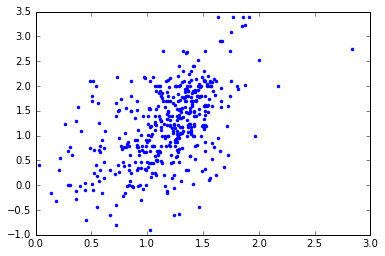

In [116]:
plt.plot(pred_y_vals,test_y,'.')

In [114]:
baseline_error_all = np.var(labels)
baseline_error_train = np.var(train_y)
baseline_error_test = np.var(test_y)
print baseline_error_all
print baseline_error_train
print baseline_error_test
print ridge_model.coef_

0.6018234403825626
0.6015933156592143
0.5992814034677354
[-0.1145207  -0.09345988 -0.03273606  0.12398654  0.07433362  0.06671675
 -0.03975804 -0.01845875  0.028491   -0.02843606 -0.00723681 -0.02923517
 -0.06974946 -0.04973211 -0.0540118  -0.03656435 -0.0590887  -0.09681256
  0.00796796 -0.01268875 -0.0231873 ]
